In [30]:
import polars as pl
import numpy as np
import math, json
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
        'font.family': 'serif',
        "font.serif": 'Times',
        'font.size': 15,
        'text.usetex': True,
        'pgf.rcfonts': False,
        'text.latex.preamble': r'\usepackage{amsmath}'
})

warmup_time = 5.0
num_runs = 15

color_M1 = '#7BBE76'
color_M2 = '#0087AC'
color_M3 = '#323B81'

color_C1 = '#FFC913'
color_C2 = '#F20052'
color_C3 = '#8B1F69'

v = '019'
per = 5
num_malicios = 60

results_path = '/home/manav/uav-position-verification-simulator'


In [31]:
def get_summary(fname):
    with open(fname, 'r') as f:
        return json.load(f)

In [32]:
def calculate_confidence_interval(data, confidence=.95):
    n = len(data)
    m = np.mean(data)
    std_dev = scipy.stats.sem(data)
    h = std_dev * scipy.stats.t.ppf((1 + confidence) / 2, n - 1)
    return [m, h]

In [33]:
def get_false_positive_rate_for_li(method, lying_intensity):
    false_positive_rates = []

    #malicious_nodes = list(range(0, 500, 5))
    for r in range(num_runs):
        try:
            summary = get_summary(f'{results_path}/res/v{v}/summary-{method}_l{lying_intensity}_m{num_malicios}_per{per}_r{r}.json')
            malicious_nodes = summary['malicious_nodes']
            df = pl.read_csv(f'{results_path}/res/v{v}/{method}_l{lying_intensity}_m{num_malicios}_per{per}_r{r}.csv')
            false_positives = df.filter(~pl.col("detected_node").is_in(malicious_nodes))

            false_positive_rates.append(len(false_positives) / len(df))

        except:
            pass

    if len(false_positive_rates) == 0:
        return (0,0)    


    [m,h] = calculate_confidence_interval(false_positive_rates)
    return (m,h)

def get_false_positive_rate(method, lying_intensities):
    means = []
    cis = []
    for l in lying_intensity:
        (m,ci) = get_false_positive_rate_for_li(method, l)
        means.append(m)
        cis.append(ci)

    return (np.array(means), np.array(cis))

In [34]:
lying_intensity = np.arange(0,505,5)
lying_intensity = [100]

PEPT, PEPT_CI = get_false_positive_rate('PEPT', lying_intensity)
REPT, REPT_CI = get_false_positive_rate('REPT', lying_intensity)

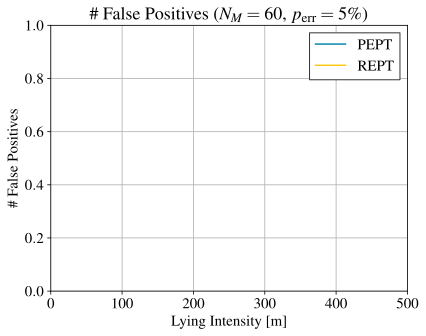

In [35]:
ART_COLOR = color_C2
MGT_COLOR = color_M1
PEPT_COLOR = color_M2
REPT_COLOR = color_C1

fig, ax = plt.subplots()
#plt.yscale('log')

ax.plot(lying_intensity, PEPT, label="PEPT", color=PEPT_COLOR)
ax.fill_between(lying_intensity, (PEPT - PEPT_CI), (PEPT + PEPT_CI), facecolor=PEPT_COLOR, interpolate=True, alpha=0.2)

ax.plot(lying_intensity, REPT, label="REPT", color=REPT_COLOR)
ax.fill_between(lying_intensity, (REPT - REPT_CI), (REPT + REPT_CI), facecolor=REPT_COLOR, interpolate=True, alpha=0.2)

ax.set_ylim([0, 1])
ax.set_xlim([0, 500])

ax.set_ylabel('\# False Positives')
ax.set_xlabel('Lying Intensity [m]')
ax.grid()

plt.title(f'\# False Positives ($N_M= {num_malicios}$, $p_\mathrm{{err}} = {per}$\%)')

leg = plt.legend(fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

plt.show()

fig.savefig(f"../figures/false_positive_rate_m{num_malicios}_per{per}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/false_positive_rate_m{num_malicios}_per{per}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

In [36]:
print('100', PEPT[lying_intensity == 100])
print('200', PEPT[lying_intensity == 200])
print('300', PEPT[lying_intensity == 300])

100 []
200 []
300 []


In [40]:
PEPT

array([0.7657607])